# Data

## Preparation

In [841]:
import pandas as pd
import numpy as np
import sqlalchemy as sql
import sklearn.preprocessing as preprocessor
import sklearn.metrics as metric
import keras.models as model
import keras.layers as layer
import math
from matplotlib import pyplot

### Simulate stock prices

In [999]:
engine = sql.create_engine('postgresql://postgres@127.0.0.1:5432/data')
x = pd.read_sql_query(
    'select timestamp, close from route_paths',
    con=engine,
    index_col='timestamp',
    parse_dates=['timestamp']
)

### Create features

In [1008]:
training_data = pd.DataFrame()
# training_data['close/sma3'] = x['close'] / (x['close'].rolling(window=3).sum() / 3)
# training_data['close/sma4'] = x['close'] / (x['close'].rolling(window=4).sum() / 4)
# training_data['close/sma5'] = x['close'] / (x['close'].rolling(window=5).sum() / 5)
# training_data['close/sma6'] = x['close'] / (x['close'].rolling(window=6).sum() / 6)
training_data['close/sma7'] = x['close'] / (x['close'].rolling(window=7).sum() / 7)

tmp_data = pd.DataFrame()
tmp_data['sma14'] = x['close'].rolling(window=14).sum() / 14
tmp_data['uband'] = tmp_data['sma14'] + (x['close'].rolling(window=14).std() * 2)
tmp_data['lband'] = tmp_data['sma14'] - (x['close'].rolling(window=14).std() * 2)

training_data['close/close-sma14'] = x['close'] / (x['close'] - tmp_data['sma14'])
training_data['close/uband-close'] = x['close'] / (tmp_data['uband'] - x['close'])
training_data['close/close-lband'] = x['close'] / (x['close'] - tmp_data['lband'])

### Modeling

In [1009]:
prediction_period = 14
training_start_index = 13

train = training_data[training_start_index:-prediction_period]
label = training_data[training_start_index + 1:-prediction_period + 1]

test = training_data[-prediction_period - 1: -1]
validate = x['close'][-prediction_period:]

In [1010]:
scaler = preprocessor.MinMaxScaler(feature_range=(-1, 1))

scaler = scaler.fit(train)

train_scaled = pd.DataFrame(scaler.transform(train), columns=train.columns)
label_scaled = pd.DataFrame(scaler.transform(label), columns=label.columns)
test_scaled = pd.DataFrame(scaler.transform(test), columns=test.columns)

label_data = label_scaled.values
train_data = train_scaled.values
test_data = test_scaled.values

In [1011]:
def fit_lstm(x, y, batch_size, epoch, neurons):    
    x = x.reshape(x.shape[0], 1, x.shape[1])
    
    sequential_model = model.Sequential()
    sequential_model.add(
        layer.LSTM(neurons,
                   batch_input_shape=(1, x.shape[1], x.shape[2]),
                   stateful=True)
    )
    sequential_model.add(
        layer.Dense(y.shape[1])
    )
    sequential_model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(epoch):
        sequential_model.fit(
            x,
            y,
            epochs=1,
            batch_size=batch_size,
            verbose=1,
            shuffle=False
        )
        sequential_model.reset_states()
    return sequential_model

lstm_model = fit_lstm(train_data, label_data, 1, 50, 1)

Epoch 1/1
366/366 [==============================] - 8s - loss: 0.0719     
Epoch 1/1
366/366 [==============================] - 2s - loss: 0.0339     
Epoch 1/1
366/366 [==============================] - 2s - loss: 0.0302     
Epoch 1/1
366/366 [==============================] - 2s - loss: 0.0298     
Epoch 1/1
366/366 [==============================] - 2s - loss: 0.0296     
Epoch 1/1
366/366 [==============================] - 3s - loss: 0.0295     
Epoch 1/1
366/366 [==============================] - 2s - loss: 0.0294     
Epoch 1/1
366/366 [==============================] - 3s - loss: 0.0294     
Epoch 1/1
366/366 [==============================] - 3s - loss: 0.0293     
Epoch 1/1
366/366 [==============================] - 3s - loss: 0.0293     
Epoch 1/1
366/366 [==============================] - 2s - loss: 0.0293     
Epoch 1/1
366/366 [==============================] - 2s - loss: 0.0293     
Epoch 1/1
366/366 [==============================] - 2s - loss: 0.0292     
Epoch 1/1
36

In [1012]:
predictions = validate.copy()

sma3 = x['close'].rolling(window=3).sum() / 3

for i in range(test_data.shape[0]):
    forecasting_value = lstm_model.predict(
        test_data[i, :].reshape(1, 1, test_data.shape[1]),
        batch_size=1
    )
    inversed_forecast = scaler.inverse_transform(forecasting_value.reshape(1, test_data.shape[1]))[0]
    inversed_forecast = inversed_forecast[0] * sma3[-prediction_period + i - 1]
    predictions[i] = inversed_forecast
    expected = validate[i]
    print("day = %d, predicted = %f, expected = %f" % (i + 1, inversed_forecast, expected))

day = 1, predicted = 9679.228939, expected = 8521.000000
day = 2, predicted = 9362.976935, expected = 8580.000000
day = 3, predicted = 9073.259427, expected = 7750.000000
day = 4, predicted = 8581.300108, expected = 7000.000000
day = 5, predicted = 7868.673688, expected = 7180.000000
day = 6, predicted = 7323.047770, expected = 7090.000000
day = 7, predicted = 7065.507550, expected = 6600.000000
day = 8, predicted = 6877.426290, expected = 6117.000000
day = 9, predicted = 6464.720315, expected = 5390.000000
day = 10, predicted = 5828.510014, expected = 5813.000000
day = 11, predicted = 5579.592782, expected = 7000.000000
day = 12, predicted = 5987.165242, expected = 7798.000000
day = 13, predicted = 6962.108863, expected = 7306.000000
day = 14, predicted = 7563.355545, expected = 7280.000000


In [1013]:
rmse = math.sqrt(
    metric.mean_squared_error(
        validate.values,
        predictions.values
    )
)
rmse

1006.4114400046262

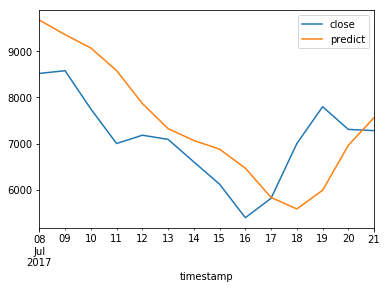

In [1014]:
validate_data_frame = pd.DataFrame(validate)
validate_data_frame['predict'] = predictions
validate_data_frame.plot()
pyplot.show()